#   <center>**Federated Averaging**</center>

# 1. Description
This notebook implments the Federated Averaging (**FedAvg**) Algorithm. To make the notebook self-contained, we include the pseudo-code and minimal description of the setup below but the reader is encouraged to read the full paper from [here](https://arxiv.org/pdf/1602.05629.pdf).

We consider $K$ clients over which the data is partitioned, with $\mathcal{P}_k$ the set of indexes of data points on client $k$, with $n_k = |\mathcal{P}_k|$. FedAvg was proposed to solve any finite-sum objective of the form

\begin{equation}
\underset{w \in \mathbb{R}^d}{\min} f(w) = \sum_{k=1}^k \frac{n_k}{n} F_k(w) \text{ where } F_k(w) = \frac{1}{n_k} \sum_{i \in \mathcal{P}_k} f_i(w)
\end{equation}
For a machine learning problem, we typically take $f_i(w) = \ell(x_i, y_i; w)$, i.e. the loss of the prediction on the example $(x_i, y_i)$ made with model parameters $w$.














# 2. Notations and Pseudo-code

Before writing the FedAvg pseudo-code, we define the following quantities:


*   $B$ : the local minibatch size
*   $E$ : the number of local epochs or communication inverval
*   $\eta$ : the learning rate
*   $C$ : the client fraction
*   $T$ : the total number of communication rounds

Note that when $B = \infty$ and $E=1$, the FedAvg is equivalent to FederatedSGD, where $B = \infty$ indices that the full local dataset is treated as a single minibatch.

---

**PseudoCode** of FedAvg Algorithm

---
**Server executes:**
> Initialize $w_0$ <br>
> **for** each round $t = 1, 2, \dots, T$ **do**
>> $m \leftarrow \max(C \cdot K, 1)$ <br>
>> $S_t \leftarrow$ (random set of $m$ clients)  <br>
>> **for** each client $k \in S_t$ **in parallel do**
>>> $w^{k}_{t+1} \leftarrow$ ClientUpdate($k$, $w_{t}$) 

>>  $w_{t+1} = \sum_{k=1}^{K} \frac{n_k}{n} w^{k}_{t+1}$

**ClientUpdate($k$, $w$):** // Run on client $k$
> $\mathcal{B} \leftarrow$ (split $\mathcal{P}_k$ into batches of size $B$) <br>
> **for** each local epoch $i = 1, 2, \dots, E$ **do**
>> **for** batch $b \in \mathcal{B}$ **do**
>>> $w \leftarrow w − \eta \nabla \ell(w, b)$ 

> return $w$ to server

---

# 3. Implementation


## 3.1 Importing Required Modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 3.2 Simulation Setting
We start by specifying the parameters of our simulation setting. For the sake of consistency, we use the same variable names as described above. Note that here we are specifying different batch sizes (*B*) for the training part and (*B_test*) for the test part.

In [2]:
T = 100
C = 0.1
K = 100
E = 1
eta = 0.01
B = 10
B_test = 128

## 3.3 Loading Dataset
For illustration purpose, we will consider the same dataset as in the original paper, i.e. MNIST dataset. When loading the dataset, we get the train (*mnist_data_train*) and the test (*mnist_data_test*) partitions while applying the transformer that enables us to convert the data to tensor and normalize it.

In [3]:
def load_dataset():
    transforms_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])
    mnist_data_train = datasets.MNIST('./data/mnist', train=True, download=True, transform=transforms_mnist)
    mnist_data_test = datasets.MNIST('./data/mnist', train=False, download=True, transform=transforms_mnist)

    return mnist_data_train, mnist_data_test

In [4]:
mnist_data_train, mnist_data_test = load_dataset()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 3.4 Data Partioning
For the data partitioning, we define two functions to replicate data partitioning in real world scenario:
- **iid_partition** : generates an identical and independent distributed (IID) partitioning of the dataset, i.e. the data is shuffled, then uniformly distributed across clients.
- **non_iid_partition** : pathological implementation of a non-IID setting where each client gets data from only a subset of classes. We first sort the data by digit label, then divided into (*total_shards*) shards of size (*shards_size*) and assign each client (*num_shards_per_client*) shards.


In [5]:
def iid_partition(dataset, K):
    num_items_per_client = int(len(dataset)/K)
    client_dict = {}
    image_idxs = [i for i in range(len(dataset))]

    for i in range(K):
        client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
        image_idxs = list(set(image_idxs) - client_dict[i])

    return client_dict

In [6]:
def non_iid_partition(dataset, K, total_shards, shards_size, num_shards_per_client):
    shard_idxs = [i for i in range(total_shards)]
    client_dict = {i: np.array([], dtype='int64') for i in range(K)}
    idxs = np.arange(len(dataset))
    data_labels = dataset.targets.numpy()

    # sort the labels
    label_idxs = np.vstack((idxs, data_labels))
    label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
    idxs = label_idxs[0,:]

    # divide the data into total_shards of size shards_size
    # assign num_shards_per_client to each client
    for i in range(K):
        rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
        shard_idxs = list(set(shard_idxs) - rand_set)

        for rand in rand_set:
            client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
    return client_dict

## 3.5 Model Definition
In this subsection, we define the neural net (NN) models. To this end, we provide two classes **MLP_Net** and **CNN_Net** that replicates the Multi-Layer Perceptron (MLP) and Convolutional Neural Network (CNN) models, respectively, from the original paper.

In [7]:
class MLP_Net(nn.Module):
    def __init__(self):
        super(MLP_Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out

In [8]:
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        out = F.log_softmax(x, dim=1)
        return out

## 3.6 Local Dataset
We implement the function **CustomDataset** that generates the corresponding data samples according to the dictionary of indices obtained from the data partioning from either the **iid_partition** or the **non_iid_partition** functions.

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

## 3.7 Client Update
In this subsection, we implement the local training of the model on the client side. Note that we use SGD optimizer following the paper, other types of optimizers (Adam, RMSprop,...) can be used.

In [10]:
class ClientUpdate(object):
    def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
        self.learning_rate = learning_rate
        self.epochs = epochs

    def train(self, model):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

        e_loss = []
        for epoch in range(1, self.epochs+1):
            train_loss = 0
            model.train()
            for data, labels in self.train_loader:
                optimizer.zero_grad() 
                output = model(data)  
                loss = criterion(output, labels) 
                loss.backward() 
                optimizer.step() 
                train_loss += loss.item()*data.size(0) 

            train_loss = train_loss/len(self.train_loader.dataset) 
            e_loss.append(train_loss)

        total_loss = sum(e_loss)/len(e_loss)

        return model.state_dict(), total_loss

## 3.8 Test Loss and Accuracy

The function **testing** is used to evaluate the performance of the global model on the test dataset in terms of the loss as well as the accuracy.

In [11]:
def testing(model, dataset, bs, criterion): 
    test_loss = 0
    correct = 0
    test_loader = DataLoader(dataset, batch_size=bs)
    l = len(test_loader)
    model.eval()
    for data, labels in test_loader:
        output = model(data)
        loss = criterion(output, labels)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        correct += pred.eq(labels.data.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

## 3.9 Algorithm Implementation: 
In the below cell, we provide the implementation of FedAvg using the above helping functions where the loss function is the cross entropy. In this notebook, we chose an IID partition of the data and a CNN model. Students are encouraged to play with the hyperparameters, try different data partitioning as well different models (MLP/CNN).

In [13]:
iid_dict = iid_partition(mnist_data_train, K)
model = CNN_Net()
criterion = nn.CrossEntropyLoss()
ds = mnist_data_train
data_dict = iid_dict
global_weights = model.state_dict() 
train_loss = []
test_loss = []
test_accuracy = []

for curr_round in tqdm(range(1, T+1)):
    #print('Round ',curr_round)
    w, local_loss = [], []
    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
        local_update = ClientUpdate(dataset=ds, batchSize=B, learning_rate=eta, epochs=E, idxs=data_dict[k])
        weights, loss = local_update.train(model=copy.deepcopy(model))
        w.append(copy.deepcopy(weights))
        local_loss.append(copy.deepcopy(loss))


    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
        for i in range(1, len(w)):
            weights_avg[k] += w[i][k]

        weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg


    model.load_state_dict(global_weights)
        
    loss_avg = sum(local_loss) / len(local_loss)
    train_loss.append(loss_avg)

    g_loss, g_accuracy = testing(model, mnist_data_test, B_test, criterion)

    test_loss.append(g_loss)
    test_accuracy.append(g_accuracy)

100%|██████████| 100/100 [26:48<00:00, 16.08s/it]


## 3.10 Plotting Results
In this subsection, we plot some results for the training/test loss as well as the test accuracy.

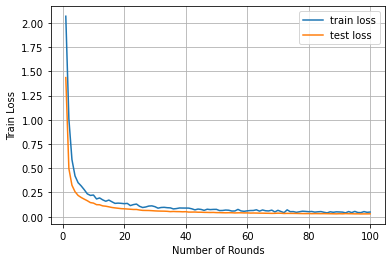

In [18]:
fig, ax = plt.subplots()
x_axis = np.arange(1, T+1)
y_axis = np.array(train_loss)
ax.plot(x_axis, y_axis, label = "train loss")

y_axis = np.array(test_loss)
ax.plot(x_axis, y_axis, label = "test loss")

ax.set(xlabel='Number of Rounds', ylabel='Train Loss')
ax.legend()
ax.grid()

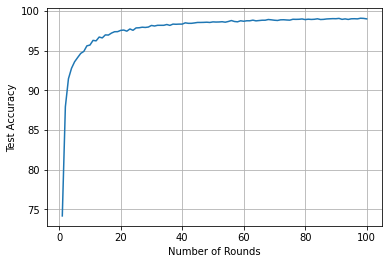

In [19]:
fig, ax = plt.subplots()
x_axis = np.arange(1, T+1)
y_axis = np.array(test_accuracy)
ax.plot(x_axis, y_axis)

ax.set(xlabel='Number of Rounds', ylabel='Test Accuracy')
ax.grid()